In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

Load data

In [3]:
data_read = pd.read_csv('data_min_total.csv')
data_read['DateTime'] = pd.to_datetime(data_read['DateTime'], format='%d/%m/%Y %H:%M')
data = data_read[data_read['DateTime'] <= '2025-04-30'].copy()

#data.set_index('Datetime', inplace=True)
print(data.tail())

                 DateTime  Bid1_Price  Bid1_Volume  Ask1_Price  Ask1_Volume  \
41802 2025-04-29 15:55:00      182.21         3133      237.46         1883   
41803 2025-04-29 15:56:00      184.67         3277      237.71         1376   
41804 2025-04-29 15:57:00      182.26         1817      223.34         1941   
41805 2025-04-29 15:58:00      180.46         2567      242.33         1489   
41806 2025-04-29 15:59:00      178.22         1799      217.13         1203   

       Bid2_Price  Bid2_Volume  Ask2_Price  Ask2_Volume  Mid-Price  ...  \
41802      175.40         3132      285.35         1738     209.84  ...   
41803      182.92         2383      300.78         1422     211.19  ...   
41804      170.59         2132      262.83         1978     202.80  ...   
41805      169.14         1810      302.57         1340     211.40  ...   
41806      160.69         2143      286.66         1405     197.67  ...   

       Market_Depth_Ask  Historical_Volatility  Total_volume  \
41802     

Run Simulation

In [4]:
# Initial conditions
initial_cash = 10000  # Starting cash
cash = initial_cash
shares_owned = 0  # Starting shares owned
transactions = []  # List to record transactions

# Parameters for market impact, slippage, and fees
market_impact_constant = 0.1
average_daily_volume = data['Mid-Price'].count()  # Using total count as a proxy
brokerage_fee_bps = 0.50 / 100
exchange_fee_per_share = 0.000025
shares_per_transaction = 500

# Thresholds
bid_ask_spread_threshold = data['Bid_Ask_Spread'].quantile(0.5)  # Liquidity - median spread as threshold 
order_imbalance_threshold = 0.10  # Volume - placeholder value

# if moving average then define the window size for the moving average
sma_window_size = 10
# Calculate the SMA for Mid-Price
data['SMA_Mid_Price'] = data['Mid-Price'].rolling(window=sma_window_size).mean()

# Holding Threshilds
volatility_threshold = 0.05  # Placeholder for volatility threshold
proximity_threshold = 0.02  # Placeholder for how close the price should be to the SMA to consider holding

# Run simulation
for i in range(sma_window_size, len(data)):
    current_mid_price = data.iloc[i]['Mid-Price']
    average_mid_price = data.iloc[i]['SMA_Mid_Price']
    order_imbalance = data.iloc[i]['Order_imbalance']
    bid_ask_spread = data.iloc[i]['Bid_Ask_Spread']  # Use the actual column for bid-ask spread
    is_liquid = bid_ask_spread <= bid_ask_spread_threshold and abs(order_imbalance) <= order_imbalance_threshold
    price_proximity = abs(current_mid_price - average_mid_price) / average_mid_price
    volatility = data.iloc[i]['Historical_Volatility']
    is_hold_condition = (price_proximity < proximity_threshold or volatility > volatility_threshold)

    # Buy condition
    if current_mid_price < average_mid_price and is_liquid:
        shares_to_buy = min(shares_per_transaction, int(cash / (current_mid_price + brokerage_fee_bps * current_mid_price + exchange_fee_per_share)))
        if shares_to_buy > 0:
            volume_ratio = shares_to_buy / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_buy_price = current_mid_price + price_impact
            total_cost = adjusted_buy_price * shares_to_buy + brokerage_fee_bps * adjusted_buy_price * shares_to_buy + exchange_fee_per_share * shares_to_buy
            cash -= total_cost
            shares_owned += shares_to_buy
            transactions.append(('Buy', shares_to_buy, adjusted_buy_price, total_cost, cash, i))
    
    # Sell condition
    elif current_mid_price > average_mid_price and is_liquid and shares_owned > 0:
        volume_ratio = shares_owned / average_daily_volume
        price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
        adjusted_sell_price = current_mid_price - price_impact
        total_revenue = adjusted_sell_price * shares_owned - brokerage_fee_bps * adjusted_sell_price * shares_owned - exchange_fee_per_share * shares_owned
        cash += total_revenue
        transactions.append(('Sell', shares_owned, adjusted_sell_price, total_revenue, cash, i))
        shares_owned = 0

    # Hold condition
    elif is_hold_condition:
        # Log hold action if conditions suggest increased risk or uncertainty
        transactions.append(('Hold', shares_owned, current_mid_price, 0, cash, i))

num_hold_signals = sum(1 for transaction in transactions if transaction[0] == 'Hold')
num_buy_signals = sum(1 for transaction in transactions if transaction[0] == 'Buy')
num_sell_signals = sum(1 for transaction in transactions if transaction[0] == 'Sell')
final_valuation = cash + shares_owned * data.iloc[-1]['Mid-Price']

output = {
    "Initial Cash": initial_cash,
    "Final Valuation": final_valuation,
    "Overall Profit/Loss": final_valuation - initial_cash,
    "Number of Transactions": len(transactions),
    #"First 5 Transactions": transactions[:5],
    "Number of Hold Signals": num_hold_signals,
    "Number of Buy Signals": num_buy_signals,
    "Number of Sell Signals": num_sell_signals,
}

print(output)


{'Initial Cash': 10000, 'Final Valuation': 22035.32225364357, 'Overall Profit/Loss': 12035.322253643571, 'Number of Transactions': 38132, 'Number of Hold Signals': 35429, 'Number of Buy Signals': 1352, 'Number of Sell Signals': 1351}


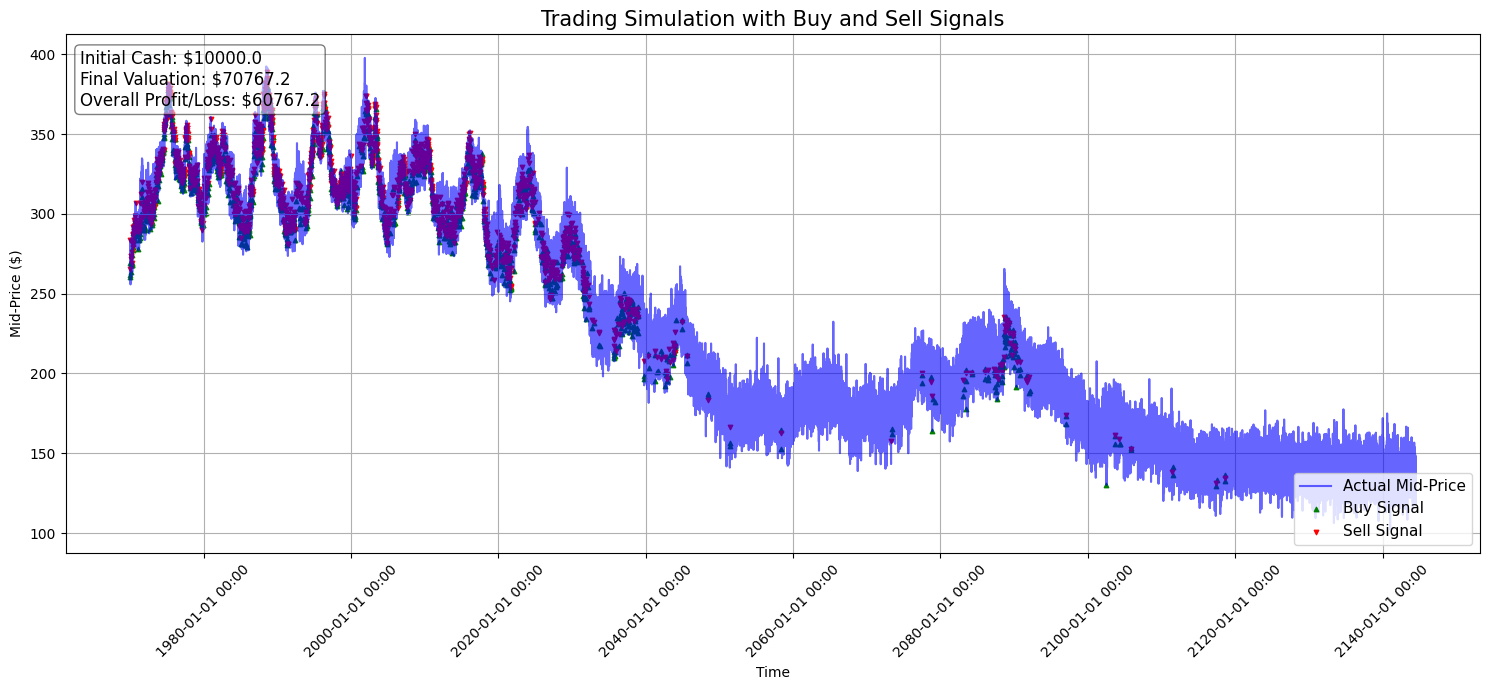

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert transactions to a df
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Shares', 'Price', 'Total Cost', 'Cash After', 'Time'])
# 'Time' in transactions was an index in transactions so map it to a Datetime
transactions_df['Datetime'] = transactions_df['Time'].apply(lambda x: data.iloc[x]['DateTime'])

# plot
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(data['DateTime'], data['Mid-Price'], label='Actual Mid-Price', color='blue', alpha=0.6)
#ax.plot(data['DateTime'], data['SMA_Mid_Price'], label='SMA Mid-Price', color='darkorange', alpha=0.8)

# add buy and sell signals
buy_signals = transactions_df[transactions_df['Action'] == 'Buy']
sell_signals = transactions_df[transactions_df['Action'] == 'Sell']
ax.scatter(buy_signals['Datetime'], buy_signals['Price'], label='Buy Signal', color='green', marker='^', s=10, alpha=1.0)
ax.scatter(sell_signals['Datetime'], sell_signals['Price'], label='Sell Signal', color='red', marker='v', s=10, alpha=1.0)

# format the x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# Add labels with model results
final_valuation = final_valuation  # From the previous output
text_str = f'Initial Cash: ${initial_cash:.1f}\nFinal Valuation: ${final_valuation:.1f}\nOverall Profit/Loss: ${final_valuation - initial_cash:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Position the text on the axes (adjust the x and y values based on your plot's layout)
ax.text(0.01, 0.97, text_str, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_title('Trading Simulation with Buy and Sell Signals', fontsize=15)
ax.set_xlabel('Time')
ax.set_ylabel('Mid-Price ($)')
ax.legend(loc='lower right', fontsize=11)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


Export the figure

In [34]:
fig.savefig('Trading Simulation ARIMA1 Results Rolling.png', dpi=600, bbox_inches='tight')

In [54]:
def calculate_sortino_ratio(daily_returns, risk_free_rate=0.01):
    negative_returns = daily_returns[daily_returns < 0]
    downside_deviation = np.std(negative_returns, ddof=1)
    excess_daily_returns = daily_returns - risk_free_rate / 365
    sortino_ratio = np.mean(excess_daily_returns) / downside_deviation
    return sortino_ratio * np.sqrt(252)  # Annualize

def calculate_sharpe_ratio(daily_returns, risk_free_rate=0.01):
    excess_daily_returns = daily_returns - risk_free_rate / 365
    sharpe_ratio = np.mean(excess_daily_returns) / np.std(excess_daily_returns, ddof=1)
    return sharpe_ratio * np.sqrt(252)  # Annualize

def calculate_maximum_drawdown(cumulative_returns):
    # Ensure cumulative_returns is not empty
    if len(cumulative_returns) > 0:
        running_max = np.maximum.accumulate(cumulative_returns)
        # Avoid division by zero by ensuring running_max is always greater than zero
        running_max_nonzero = np.where(running_max == 0, np.nan, running_max)
        drawdown = (running_max_nonzero - cumulative_returns) / running_max_nonzero
        max_drawdown = np.nanmax(drawdown)  # Drawdowns are negative values
        return -max_drawdown if not np.isnan(max_drawdown) else 0  # Return positive value for max drawdown
    else:
        return 0  # Return 0 if there's no variation or data is empty

def calculate_calmar_ratio(annual_return, max_drawdown):
    # Assuming max_drawdown is negative, make it positive for the ratio
    return annual_return / abs(max_drawdown)

In [57]:
def run_trading_simulation(sma_window_size, bid_ask_spread_threshold, order_imbalance_threshold, volatility_threshold, proximity_threshold):
    # Initial conditions
    initial_cash = 10000  # Starting cash
    cash = initial_cash
    shares_owned = 0  # Starting shares owned
    transactions = []  # List to record transactions
    daily_portfolio_values = []  # Track daily portfolio values for performance metrics calculation

    # Parameters for market impact, slippage, and fees
    market_impact_constant = 0.1
    average_daily_volume = data['Mid-Price'].count()  # Using total count as a proxy
    brokerage_fee_bps = 0.50 / 100
    exchange_fee_per_share = 0.000025
    shares_per_transaction = 500
  
    data['SMA_Mid_Price'] = data['Mid-Price'].rolling(window=sma_window_size).mean()

    # Trading simulation loop (buy, sell, hold logic)
    # Run simulation
    for i in range(sma_window_size, len(data)):
        current_mid_price = data.iloc[i]['Mid-Price']
        average_mid_price = data.iloc[i]['SMA_Mid_Price']
        order_imbalance = data.iloc[i]['Order_imbalance']
        bid_ask_spread = data.iloc[i]['Bid_Ask_Spread']  # Use the actual column for bid-ask spread
        is_liquid = bid_ask_spread <= bid_ask_spread_threshold and abs(order_imbalance) <= order_imbalance_threshold
        price_proximity = abs(current_mid_price - average_mid_price) / average_mid_price
        volatility = data.iloc[i]['Historical_Volatility']
        is_hold_condition = (price_proximity < proximity_threshold or volatility > volatility_threshold)

        # Buy condition
        if current_mid_price < average_mid_price and is_liquid:
            shares_to_buy = min(shares_per_transaction, int(cash / (current_mid_price + brokerage_fee_bps * current_mid_price + exchange_fee_per_share)))
            if shares_to_buy > 0:
                volume_ratio = shares_to_buy / average_daily_volume
                price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
                adjusted_buy_price = current_mid_price + price_impact
                total_cost = adjusted_buy_price * shares_to_buy + brokerage_fee_bps * adjusted_buy_price * shares_to_buy + exchange_fee_per_share * shares_to_buy
                cash -= total_cost
                shares_owned += shares_to_buy
                transactions.append(('Buy', shares_to_buy, adjusted_buy_price, total_cost, cash, i))
        
        # Sell condition
        elif current_mid_price > average_mid_price and is_liquid and shares_owned > 0:
            volume_ratio = shares_owned / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * current_mid_price
            adjusted_sell_price = current_mid_price - price_impact
            total_revenue = adjusted_sell_price * shares_owned - brokerage_fee_bps * adjusted_sell_price * shares_owned - exchange_fee_per_share * shares_owned
            cash += total_revenue
            transactions.append(('Sell', shares_owned, adjusted_sell_price, total_revenue, cash, i))
            shares_owned = 0

        # Hold condition
        elif is_hold_condition:
            # Log hold action only if conditions suggest increased risk or uncertainty
            transactions.append(('Hold', shares_owned, current_mid_price, 0, cash, i))

        # Update the portfolio value for each day
        portfolio_value = cash + shares_owned * current_mid_price
        daily_portfolio_values.append(portfolio_value)
    
    # Calculate daily returns from portfolio values
    daily_returns = pd.Series(daily_portfolio_values).pct_change().dropna()
    
    # Performance Metrics
    sortino_ratio = calculate_sortino_ratio(daily_returns)
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    cumulative_returns = (1 + daily_returns).cumprod() - 1
    max_drawdown = calculate_maximum_drawdown(cumulative_returns)
    if len(data) > 0 and (cumulative_returns.iloc[-1] + 1) > 0:
        annual_return = (cumulative_returns.iloc[-1] + 1) ** (365 / len(data)) - 1
    else:
        # Handle cases where annual return cannot be computed traditionally
        annual_return = None  # Or other appropriate handling
    calmar_ratio = calculate_calmar_ratio(annual_return, max_drawdown)
    
    # Return the overall profit or loss for this simulation run
    final_valuation = cash + shares_owned * data.iloc[-1]['Mid-Price']
    return final_valuation - initial_cash, transactions, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio, daily_returns
    
# Parameter ranges (example ranges, adjust as needed)
sma_window_sizes = [10, 15, 20]
bid_ask_thresholds = [int(data['Bid_Ask_Spread'].quantile(0.4)), int(data['Bid_Ask_Spread'].quantile(0.5)), int(data['Bid_Ask_Spread'].quantile(0.5))]
order_imbalance_thresholds = [0.01, 0.02, 0.03]
volatility_thresholds = [0.04, 0.05, 0.06]
proximity_thresholds = [0.01, 0.02, 0.03]

results = []

# Iterating over all combinations of parameters
for sma_size in sma_window_sizes:
    for bid_ask_thresh in bid_ask_thresholds:
        for order_imbalance_thresh in order_imbalance_thresholds:
            for volatility_thresh in volatility_thresholds:
                for proximity_thresh in proximity_thresholds:
                    profit_loss, transactions, sortino_ratio, sharpe_ratio, max_drawdown, calmar_ratio, daily_returns = run_trading_simulation(sma_size, bid_ask_thresh, order_imbalance_thresh, volatility_thresh, proximity_thresh)
                    results.append((sma_size, bid_ask_thresh, order_imbalance_thresh, volatility_thresh, proximity_thresh, profit_loss, len(transactions), sharpe_ratio, sortino_ratio, max_drawdown, calmar_ratio))


# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results, columns=['SMA Size', 'Bid-Ask Thresh', 'Order Imbalance Thresh', 'Volatility Thresh', 'Proximity Thresh', 'Profit/Loss', 'Number of Transactions', 'Sortino Ratio', 'Sharpe Ratio', 'Max Drawdown', 'Calmar Ratio'])
print(results_df.head(50))
results_df.to_csv('Threshold Test Results.csv')

    SMA Size  Bid-Ask Thresh  Order Imbalance Thresh  Volatility Thresh  \
0         10              20                    0.01               0.04   
1         10              20                    0.01               0.04   
2         10              20                    0.01               0.04   
3         10              20                    0.01               0.05   
4         10              20                    0.01               0.05   
5         10              20                    0.01               0.05   
6         10              20                    0.01               0.06   
7         10              20                    0.01               0.06   
8         10              20                    0.01               0.06   
9         10              20                    0.02               0.04   
10        10              20                    0.02               0.04   
11        10              20                    0.02               0.04   
12        10             

In [1]:
import matplotlib.pyplot as plt

# Assuming daily_returns is a pandas Series containing your daily return values
plt.figure(figsize=(14, 7))  # Set the figure size for better readability
plt.plot(daily_returns, marker='o', linestyle='-', markersize=4)
plt.title('Daily Returns Over Time')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Daily Return')  # Y-axis label
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid for easier readability
plt.tight_layout()  # Adjust the layout to make room for the plot labels

# If the index of daily_returns is not already a datetime index, you might want to convert it for better x-axis labels
# daily_returns.index = pd.to_datetime(daily_returns.index)

plt.show()

NameError: name 'daily_returns' is not defined

<Figure size 1400x700 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert transactions to a df
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Shares', 'Price', 'Total Cost', 'Cash After', 'Time'])
# 'Time' in transactions was an index in transactions so map it to a Datetime
transactions_df['Datetime'] = transactions_df['Time'].apply(lambda x: data.iloc[x]['Datetime'])

# plot
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(data['Datetime'], data['Mid-Price'], label='Actual Mid-Price', color='blue', alpha=0.6)
ax.plot(data['Datetime'], data['SMA_Mid_Price'], label='SMA Mid-Price', color='darkorange', alpha=0.8)

# add buy and sell signals
buy_signals = transactions_df[transactions_df['Action'] == 'Buy']
sell_signals = transactions_df[transactions_df['Action'] == 'Sell']
ax.scatter(buy_signals['Datetime'], buy_signals['Price'], label='Buy Signal', color='green', marker='^', s=50, alpha=1.0)
ax.scatter(sell_signals['Datetime'], sell_signals['Price'], label='Sell Signal', color='red', marker='v', s=50, alpha=1.0)

# format the x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# Add labels with model results
final_valuation = final_valuation_corrected  # From the previous output
text_str = f'Initial Cash: ${initial_cash:.1f}\nFinal Valuation: ${final_valuation:.1f}\nOverall Profit/Loss: ${final_valuation - initial_cash:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Position the text on the axes (adjust the x and y values based on your plot's layout)
ax.text(0.01, 0.97, text_str, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_title('Trading Simulation with Buy and Sell Signals', fontsize=15)
ax.set_xlabel('Time')
ax.set_ylabel('Mid-Price ($)')
ax.legend(loc='lower right', fontsize=11)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


ValueError: Shape of passed values is (6, 1), indices imply (6, 6)